In [1]:
import pickle
import os
import os.path as osp
import pandas as pd
import numpy as np
import json
from tqdm.autonotebook import tqdm
from glob import glob
import sys
from collections import defaultdict
import matplotlib.pyplot as plt

project_path = osp.abspath(osp.join(os.getcwd(), os.pardir, os.pardir))
sys.path.append(project_path)

from utils import (
    get_refcoco_df, read_panoptic_anns,
    decompose_att_vector, reshape_2d_att,
    get_attended_classes
)
from configuration import Config

config = Config()

In [2]:
def parse_filename(file_path):

    filename = osp.split(file_path)[-1]
    file_stem = osp.splitext(filename)[0]
    dataset, split, architecture, context, noise, epoch, _ = file_stem.split('_')
    context = context.split(':')[-1]
    noise = noise.split(':')[-1]
    noise = float(noise.replace('-', '.'))
    epoch = int(epoch.split(':')[-1])
    
    return dataset, split, architecture, context, noise, epoch

def make_system_name(architecture, context, noise) -> str:
    
    match architecture:
        case 'clpgpt':
            architecture = 'CLIP-GPT'
        case 'trf':
            architecture = 'TRF'
    
    match context:
        case 'global':
            context = 'visual'
        case 'nocontext':
            context = 'nocontext'
        case 'scene':
            context = 'scene'
            
    return f'${architecture}_{{{context}-{noise}}}$'

In [3]:
# prepare refcoco df
refcoco_df = get_refcoco_df(config.ref_dir)

refcoco_df = refcoco_df.reset_index().groupby('ann_id').agg({
    'sent_id': list, 'caption': list, 
    'ref_id': 'first', 'refcoco_split': 'first', 
    'coco_split': 'first', 'image_id': 'first', 
    'bbox': 'first', 'category_id':'first',
}).reset_index()
refcoco_df = refcoco_df.set_index('ann_id')

with open(osp.join(config.ref_dir, 'instances.json'), 'r') as f:
    data = json.load(f)
    refcoco_categories = data['categories']
    categories_df = pd.DataFrame(refcoco_categories)

categories_df = categories_df.rename(columns={'id': 'category_id'})
refcoco_df = pd.merge(
    refcoco_df.reset_index(), 
    categories_df,
    left_on='category_id',
    right_on='category_id'
).set_index('ann_id')

# prepare panoptic anns
p_ann_pth = osp.join(config.panoptic_anns, 'panoptic_train2017.json')
p_img_dir = osp.join(config.panoptic_anns, 'panoptic_train2017')
panoptic_df, panoptic_categories = read_panoptic_anns(p_ann_pth)

In [4]:
_refcoco_categories = {r['id']: r for r in refcoco_categories}

for i, refcoco_data in _refcoco_categories.items():
    panoptic_data = panoptic_categories[i]
    assert panoptic_data['supercategory'] == refcoco_data['supercategory'] 
    assert panoptic_data['name'] == refcoco_data['name']

In [5]:
generated_dir = osp.join(project_path, 'generated', 'generated_expressions')
input_files = sorted(glob(f'{generated_dir}/refcoco/TRF/*_global/*_testb*_generated.pkl'))

print('found input files:', *['..../'+osp.split(f)[-1] for f in input_files], sep='\n')

out_dir = generated_dir = osp.join(project_path, 'generated', 'attention_analysis')
if not osp.isdir(out_dir):
    os.mkdir(out_dir)

found input files:
..../refcoco_testb_trf_context:global_noise:0-0_epoch:05_generated.pkl
..../refcoco_testb_trf_context:global_noise:0-5_epoch:08_generated.pkl
..../refcoco_testb_trf_context:global_noise:1-0_epoch:05_generated.pkl


In [6]:
for expression_file in input_files:
    
    print(f'computing attentions for {osp.split(expression_file)[-1]}')
    
    with open(expression_file, 'rb') as f:
        generated_data = pickle.load(f)
        
    system_data = []

    for g in tqdm(generated_data):

        item_data = dict()
        
        # unpack
        e_att = g['encoder_attentions']
        d_att = g['decoder_attentions']
        ann_id = g['ann_id']
        
        item_data['ann_id'] = ann_id
        item_data['generated'] = g['expression_string']

        # retrieve entry
        entry = refcoco_df.loc[ann_id]
        
        for ed_label, att in zip(['encoder', 'decoder'], [e_att, d_att]):
            with np.errstate(all='raise'):
                # mean over generated tokens and layers
                mean_token_att = att.mean(0)  # average over tokens
                mean_layer_att = mean_token_att.mean(0)  # average over layer

                # decompose attention to target, location and context
                t_att, l_att, c_att = decompose_att_vector(mean_layer_att)

                # reshape context attention
                c_att_2d = reshape_2d_att(c_att)
                
                # compute attention to panoptic classes
                zipped_scores = get_attended_classes(
                    c_att_2d, 
                    entry.image_id, 
                    panoptic_categories, 
                    panoptic_df, 
                    p_img_dir, 
                    bbox=entry.bbox
                )
                
                # fetch info for target class
                target_class_info, target_class_att, target_class_gt = dict(zipped_scores)[entry.category_id]
                
                item_data[f'{ed_label}_tclass_att'] = target_class_att
                
                norm_target_class_att = (target_class_att/target_class_gt) if target_class_gt > 0 else 0.0
                item_data[f'{ed_label}_norm_tclass_att'] = norm_target_class_att
                
                # target / context / location alphas
                alpha_t = t_att.sum()
                alpha_c = c_att.sum()
                alpha_l = l_att.sum()

                delta_tc = (alpha_t + alpha_l) - alpha_c
                
                _alpha_t = alpha_t / (alpha_t + alpha_c)
                _alpha_c = alpha_c / (alpha_t + alpha_c)
                delta_vistc = _alpha_t - _alpha_c
                
                item_data[f'{ed_label}_alpha_t'] = alpha_t
                item_data[f'{ed_label}_alpha_c'] = alpha_c
                item_data[f'{ed_label}_alpha_l'] = alpha_l
                item_data[f'{ed_label}_delta_tc'] = delta_tc
                item_data[f'{ed_label}_delta_vistc'] = delta_vistc
                    
        # write remaining info
        item_data['supercategory'] = target_class_info['supercategory']
        item_data['category_id'] = target_class_info['id']
        item_data['name'] = target_class_info['name']
        
        # add to output list
        system_data.append(item_data)
        
    out_df = pd.DataFrame(system_data)
    
    output_filename = osp.split(expression_file)[-1].replace('_generated.pkl', '_tclassatt.csv')
    out_path = osp.join(out_dir, output_filename)
    #print(f'write results to {out_path}')
    #out_df.to_csv(out_path)

computing attentions for refcoco_testb_trf_context:global_noise:0-0_epoch:05_generated.pkl


  0%|          | 0/1810 [00:00<?, ?it/s]

computing attentions for refcoco_testb_trf_context:global_noise:0-5_epoch:08_generated.pkl


  0%|          | 0/1810 [00:00<?, ?it/s]

computing attentions for refcoco_testb_trf_context:global_noise:1-0_epoch:05_generated.pkl


  0%|          | 0/1810 [00:00<?, ?it/s]

In [7]:
processed_files = sorted(glob(f'{out_dir}/*global*'))
mean_results = defaultdict(dict)

for file in processed_files:
    dataset, split, architecture, context, noise, epoch = parse_filename(file)
    
    df = pd.read_csv(file, index_col=0)
    system_name = make_system_name(architecture, context, noise)
    
    mean_results[system_name]['encoder_tclass_att'] = df.encoder_tclass_att.mean()
    mean_results[system_name]['decoder_tclass_att'] = df.decoder_tclass_att.mean()
    
    mean_results[system_name]['encoder_norm_tclass_att'] = df.encoder_norm_tclass_att.mean()
    mean_results[system_name]['decoder_norm_tclass_att'] = df.decoder_norm_tclass_att.mean()
    
    mean_results[system_name][f'encoder_alpha_t'] = df.encoder_alpha_t.mean()
    mean_results[system_name][f'decoder_alpha_t'] = df.decoder_alpha_t.mean()
    
    mean_results[system_name][f'encoder_alpha_c'] = df.encoder_alpha_c.mean()
    mean_results[system_name][f'decoder_alpha_c'] = df.decoder_alpha_c.mean()
    
    mean_results[system_name][f'encoder_alpha_l'] = df.encoder_alpha_l.mean()
    mean_results[system_name][f'decoder_alpha_l'] = df.decoder_alpha_l.mean()
    
    mean_results[system_name][f'encoder_delta_tc'] = df.encoder_delta_tc.mean()
    mean_results[system_name][f'decoder_delta_tc'] = df.decoder_delta_tc.mean()
    
    mean_results[system_name][f'encoder_delta_vistc'] = df.encoder_delta_vistc.mean()
    mean_results[system_name][f'decoder_delta_vistc'] = df.decoder_delta_vistc.mean()
    
mean_results_df = pd.DataFrame(mean_results).T
mean_results_df['encoder_tclass_att'] = mean_results_df['encoder_tclass_att'] * 100  # convert to %
mean_results_df['decoder_tclass_att'] = mean_results_df['decoder_tclass_att'] * 100  # convert to %

In [8]:
mean_results_df

,encoder_tclass_att,decoder_tclass_att,encoder_norm_tclass_att,decoder_norm_tclass_att,encoder_alpha_t,decoder_alpha_t,encoder_alpha_c,decoder_alpha_c,encoder_alpha_l,decoder_alpha_l,encoder_delta_tc,decoder_delta_tc,encoder_delta_vistc,decoder_delta_vistc
$TRF_{visual-0.0}$,36.703853,26.943814,1.770232,1.202792,0.444869,0.526467,0.463113,0.376672,0.092018,0.096860,0.073774,0.246656,-0.020639,0.164668
$TRF_{visual-0.5}$,35.268041,40.558808,1.642367,2.047580,0.189028,0.326470,0.650410,0.529391,0.160562,0.144139,-0.300820,-0.058782,-0.550358,-0.240074
$TRF_{visual-1.0}$,35.633504,43.664659,1.698700,2.261746,0.410519,0.437452,0.582786,0.557788,0.006695,0.004760,-0.165573,-0.115576,-0.173213,-0.120816


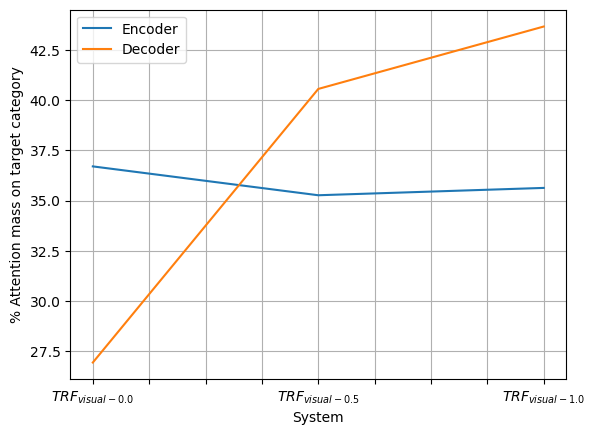

In [9]:
figure_dir = osp.join(project_path, 'generated', 'figures')

mean_results_df.encoder_tclass_att.rename('Encoder').plot(legend='left top')
mean_results_df.decoder_tclass_att.rename('Decoder').plot(legend='left top')
plt.ylabel('% Attention mass on target category')
plt.xlabel('System')
plt.grid()

plt.savefig(osp.join(figure_dir, 'attention_on_target_category.png'), pad_inches='tight')

In [10]:
mean_results_df

,encoder_tclass_att,decoder_tclass_att,encoder_norm_tclass_att,decoder_norm_tclass_att,encoder_alpha_t,decoder_alpha_t,encoder_alpha_c,decoder_alpha_c,encoder_alpha_l,decoder_alpha_l,encoder_delta_tc,decoder_delta_tc,encoder_delta_vistc,decoder_delta_vistc
$TRF_{visual-0.0}$,36.703853,26.943814,1.770232,1.202792,0.444869,0.526467,0.463113,0.376672,0.092018,0.096860,0.073774,0.246656,-0.020639,0.164668
$TRF_{visual-0.5}$,35.268041,40.558808,1.642367,2.047580,0.189028,0.326470,0.650410,0.529391,0.160562,0.144139,-0.300820,-0.058782,-0.550358,-0.240074
$TRF_{visual-1.0}$,35.633504,43.664659,1.698700,2.261746,0.410519,0.437452,0.582786,0.557788,0.006695,0.004760,-0.165573,-0.115576,-0.173213,-0.120816


In [11]:
def process_index(k):
    return tuple(k.split("_", 1))

#colums_selection = ['encoder_delta_tc', 'decoder_delta_tc', 'encoder_tclass_att', 'decoder_tclass_att']

out_df = mean_results_df.T.copy()
out_df.index = pd.MultiIndex.from_tuples([process_index(k) for k,v in out_df.iterrows()])
out_df = out_df.sort_index(ascending=False).T.round(2)

col_order = [
    ('encoder', 'delta_tc'), ('encoder', 'tclass_att'),
    ('decoder', 'delta_tc'), ('decoder', 'tclass_att')
]
out_df = out_df[col_order]

out_df = out_df.rename(columns={
    'encoder': 'Encoder',
    'decoder': 'Decoder',
    #'tclass_att': '\% Att. on target cat.',
    'tclass_att': r'$\alpha_{x=tgt}$',
    'norm_tclass_att': 'norm.',
    'alpha_t': r'$\alpha_t$',
    'alpha_c': r'$\alpha_c$',
    'alpha_l': r'$\alpha_l$',
    'delta_tc': r'$\Delta_{t,c}$'
})

out_df

Encoder                         Decoder  \
                   $\Delta_{t,c}$ $\alpha_{x=tgt}$ $\Delta_{t,c}$   
$TRF_{visual-0.0}$           0.07            36.70           0.25   
$TRF_{visual-0.5}$          -0.30            35.27          -0.06   
$TRF_{visual-1.0}$          -0.17            35.63          -0.12   

                                     
                   $\alpha_{x=tgt}$  
$TRF_{visual-0.0}$            26.94  
$TRF_{visual-0.5}$            40.56  
$TRF_{visual-1.0}$            43.66

In [12]:
print(out_df.to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{2}{l}{Encoder} & \multicolumn{2}{l}{Decoder} \\
{} & $\Delta_{t,c}$ & $\alpha_{x=tgt}$ & $\Delta_{t,c}$ & $\alpha_{x=tgt}$ \\
\midrule
$TRF_{visual-0.0}$ &           0.07 &            36.70 &           0.25 &            26.94 \\
$TRF_{visual-0.5}$ &          -0.30 &            35.27 &          -0.06 &            40.56 \\
$TRF_{visual-1.0}$ &          -0.17 &            35.63 &          -0.12 &            43.66 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_7963/893505285.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(out_df.to_latex(escape=False))
